In [1]:
import os
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import torch

device = torch.device("cpu")
seed = 0
color_map = ['#ff914d', '#68bc36', '#68bc36', '#68bc36', 'slategray', 'green', 'orange', 'olive']

In [2]:
def plot(node_idx_new, adj, mapping, pos, ax):
    plt.axis('off')
    node_idx = mapping[node_idx_new]
    sub_G = nx.from_numpy_matrix(adj[0].numpy())
    sub_G = nx.relabel_nodes(sub_G, dict(enumerate(mapping)))
    sub_G = sub_G.subgraph(nx.node_connected_component(sub_G, node_idx))
    sub_G = sub_G.copy()
    node_labels = dict([(n, n) for n in sub_G])
    fixed_nodes = pos.keys()
    for n in fixed_nodes:
        if n not in sub_G:
            sub_G.add_node(n)
    fixed_nodes = [n for n in sub_G if n in fixed_nodes]
    if fixed_nodes:
        _pos = nx.spring_layout(sub_G, seed=seed, pos=pos, fixed=fixed_nodes)
    else:
        # pos = nx.nx_agraph.graphviz_layout(G)
        _pos = nx.spring_layout(sub_G, seed=seed)
    pos.update(_pos)
    nx.draw_networkx_edges(sub_G, pos, ax=ax)
    adj = adj[0]
    if dataset == 'syn1':
        house_idx = node_idx % 5
        base_idx = node_idx - house_idx
        idx = np.zeros(5, dtype=int)
        for i in range(5):
            idx[i] = np.where(mapping==(base_idx+i))[0][0]
        adj[idx[0]][idx[1]] = 1
        adj[idx[0]][idx[3]] = 1
        adj[idx[0]][idx[4]] = 1
        adj[idx[1]][idx[2]] = 1
        adj[idx[1]][idx[4]] = 1
        adj[idx[2]][idx[3]] = 1
        adj[idx[1]][idx[0]] = 1
        adj[idx[3]][idx[0]] = 1
        adj[idx[4]][idx[0]] = 1
        adj[idx[2]][idx[1]] = 1
        adj[idx[4]][idx[1]] = 1
        adj[idx[3]][idx[2]] = 1
    sub_G = nx.from_numpy_matrix(adj.numpy())
    sub_G = nx.relabel_nodes(sub_G, dict(enumerate(mapping)))
    sub_G = sub_G.subgraph(nx.node_connected_component(sub_G, node_idx))
    sub_G = sub_G.copy()
    for n in fixed_nodes:
        if n not in sub_G:
            sub_G.add_node(n)
    fixed_nodes = pos.keys()
    fixed_nodes = [n for n in sub_G if n in fixed_nodes]
    for n in fixed_nodes:
        if n not in sub_G:
            sub_G.add_node(n)
    if fixed_nodes:
        _pos = nx.spring_layout(sub_G, seed=seed, pos=pos, fixed=fixed_nodes)
    else:
        _pos = nx.spring_layout(sub_G, seed=seed)
    pos.update(_pos)
    node_list = set(list(sub_G.nodes)) - set([node_idx])
    node_color = [color_map[sub_label[np.where(mapping == n)[0][0]]] for n in node_list]
    nx.draw_networkx_edges(sub_G, pos, alpha=0.2, ax=ax)
    nx.draw_networkx_nodes(sub_G, pos, nodelist=node_list, node_color=node_color, edgecolors='Black', node_size=50, ax=ax)
    nx.draw_networkx_nodes(sub_G, pos, nodelist=[node_idx], node_color=['Red'], edgecolors='Black', node_size=200, ax=ax)
    plt.tight_layout()
    return pos

In [11]:
def plot_node(node_idx):
    data = torch.load("distillation/%s/node_%d.ckpt" %(distillation, node_idx), map_location=device)
    mapping = data['mapping']
    node_idx_new = np.where(mapping == node_idx)[0][0]
    global sub_label
    sub_label = torch.from_numpy(data['label']).to(device).long()
    sub_adj = torch.tensor(data['adj'], dtype=torch.float, device=device)
    org_adj = sub_adj.unsqueeze(0)
    extracted_adj = torch.from_numpy(data['adj_y']).to(device).unsqueeze(0).float()

    num_nodes = sub_adj.shape[-1]

    pos = dict({})
    fig, axes = plt.subplots(figsize=(4, 4))
    pos = plot(node_idx_new, org_adj, mapping, pos, axes)
    plt.show()
    plt.close()

    data = torch.load("%s/masked_adj_node_idx_%dgraph_idx_0.ckpt" %(gnnexp_result_path, node_idx), map_location=device)
    gnnexp_mapping = data['node_idx']
    gnnexp_label = data['label'][0]

    gnnexp_adj = data['adj']
    _m = []
    for i, n in enumerate(mapping):
        _m += [np.where(gnnexp_mapping == n)[0][0]]
    _m_dict = dict([(n, i) for i, n in enumerate(_m)])
    gnnexp_mapping = gnnexp_mapping[_m]
    gnnexp_label = gnnexp_label[_m]

    pos = dict()
    adj = dict()
    merged_adj = torch.zeros((1, num_nodes,num_nodes))
    for top_k in top_ks:
        extracted_adj = np.loadtxt("explanation/%s%s/node%d_label.csv"%(explanation_prefix, top_k, node_idx), delimiter=',')
        G3 = nx.from_numpy_array(extracted_adj)
        extracted_adj = torch.from_numpy(nx.to_numpy_matrix(G3, weight=None)).unsqueeze(0).float()

        recovered = np.loadtxt("explanation/%s%s/node%d_pred.csv"%(explanation_prefix, top_k, node_idx), delimiter=',')
        ours_adj = recovered * sub_adj.numpy()
        np.fill_diagonal(ours_adj, 0)
        G2 = nx.from_numpy_array(ours_adj)
        d = nx.get_edge_attributes(G2,'weight')
        edges,weights = zip(*{k: d[k] for k in sorted(d, key=d.get)}.items())
        sub_edges = edges[-top_k:]
        G3 = nx.Graph()
        G3.add_nodes_from(list(G2.nodes))
        G3.add_edges_from(sub_edges)
        ours_adj = torch.from_numpy(nx.to_numpy_matrix(G3, weight=None)).unsqueeze(0).float()

        ### Top K or threshold ###
        gnnexp_adj_topk = np.zeros((num_nodes,num_nodes))
        if top_k is not None:
            adj_threshold_num = top_k * 2
            neigh_size = len(gnnexp_adj[gnnexp_adj > 0])
            threshold_num = min(neigh_size, adj_threshold_num)
            threshold = np.sort(gnnexp_adj[gnnexp_adj > 0])[-threshold_num]
        else:
            threshold = 1e-6
        for i in range(num_nodes):
            for j in range(num_nodes):
                if gnnexp_adj[i,j] >= threshold:
                    gnnexp_adj_topk[_m_dict[i], _m_dict[j]] = 1
        gnnexp_adj_topk = torch.from_numpy(gnnexp_adj_topk).unsqueeze(0).float()
        gnnexp_node_idx_new = np.where(gnnexp_mapping == node_idx)[0][0]

        adj[top_k] = [extracted_adj, ours_adj, gnnexp_adj_topk]
        merged_adj += extracted_adj + ours_adj + gnnexp_adj_topk

    fig, axes = plt.subplots(figsize=(2,2))
    pos = plot(node_idx_new, merged_adj, mapping, pos, axes)
#     plt.show()
    plt.close()

    fig=plt.figure(figsize=(2*len(top_ks),6))
    fig.text(-0.5,0.85,'Distillation')
    fig.text(-0.5,0.5,'Gem')
    fig.text(-0.5,0.15,'GNNExplainer')
    for idx, top_k in enumerate(top_ks):
        extracted_adj, ours_adj, gnnexp_adj_topk = adj[top_k]
        
        ax = fig.add_subplot(int(f"3{len(top_ks)}{3*idx+1}"))
        ax.set_title("K=%d" % top_k)
        pos = plot(node_idx_new, extracted_adj, mapping, pos, ax)
        
        ax = fig.add_subplot(int(f"3{len(top_ks)}{3*idx+2}"))
        pos = plot(node_idx_new, ours_adj, mapping, pos, ax)
        
        ax = fig.add_subplot(int(f"3{len(top_ks)}{3*idx+3}"))
        pos = plot(gnnexp_node_idx_new, gnnexp_adj_topk, gnnexp_mapping, pos, ax)
        
        plt.show()
        plt.close()

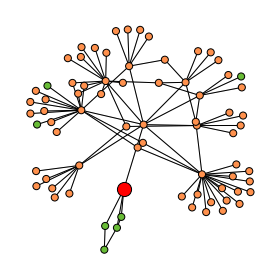

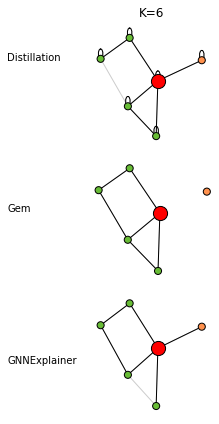

In [12]:
distillation = 'syn1_top6'
explanation_prefix = 'syn1_top'
dataset = 'syn1'
gnnexp_result_path = 'explanation/gnnexp/syn1_base_h20_o20_explain'
top_ks = [6]
plot_node(565)